In [2]:
from helper_functions import *
import numpy as np
from scipy.stats import ortho_group
from SPM import subspace_power_method
from scipy.optimize import minimize, fmin_slsqp
import pandas as pd
from ICA_code import cumulant_tensors
import matplotlib.pyplot as plt
import h5py, os
import matplotlib.pyplot as plt
from operator import itemgetter 
from scipy.sparse import vstack, coo_matrix, csc_matrix, isspmatrix_csc
from sklearn.metrics import silhouette_score
from pcpca import PCPCA
from contrastive import CPCA
from os.path import join as pjoin
from scipy.io import mmread
from sklearn.decomposition import PCA
import torch
from cICA_functions import *

In [4]:
import tikzplotlib
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [5]:
from numpy.linalg import slogdet
inv = np.linalg.inv
def make_L(X):
        p = X.shape[0]
        unobserved_idx = np.where(np.isnan(X))[0]
        observed_idx = np.setdiff1d(np.arange(p), unobserved_idx)
        L = np.zeros((observed_idx.shape[0], p))
        for ii, idx in enumerate(observed_idx):
            L[ii, idx] = 1
        return L

def log_likelihood_fg(X, W, sigma2):
    p, n = X.shape
    Ls = [make_L(X[:, ii]) for ii in range(n)]

    As = [Ls[ii] @ (W @ W.T + sigma2 * np.eye(p)) @ Ls[ii].T for ii in range(n)]

    running_sum_X = 0
    for ii in range(n):
        L = Ls[ii]
        A = As[ii]
        x = L @ np.nan_to_num(X[:, ii], nan=0)
        Di = L.shape[0]
        A_inv = inv(A)

        curr_summand = (
            Di * np.log(2 * np.pi) + slogdet(A)[1] + np.trace(A_inv @ np.outer(x, x))
        )
        running_sum_X += curr_summand

    LL = -0.5 * running_sum_X

    return LL

In [ ]:
from sklearn.metrics import adjusted_rand_score as ARC
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import normalized_mutual_info_score as NMI

def Kmeans_based_score(X,direction,label):
    kmeans=KMeans(n_clusters=2,init='k-means++')
    predicted_label=kmeans.fit_predict(X@direction)
    return ARC(label,predicted_label),NMI(label,predicted_label)

def SVC_based_score(X,direction,label):
    clf=SVC(kernel='linear')
    clf.fit(X@direction,label)
    predicted_label=clf.predict(X@direction)
    return ARC(label,predicted_label),NMI(label,predicted_label)

## Mice data

In [4]:
# mouse data

# Read in data
data = pd.read_excel('mouse_data/Data_Cortex_Nuclear.xlsx')

# Separate into background and foreground data
# In this case,
# background data is data from mice who did not receive shock therapty
# foreground data is from mice who did receive shock therapy


# Get names of proteins
protein_names = data.columns.values[1:78]

# Fill NAs
data = data.fillna(0)

# Background
Y_df = data[
    (data.Behavior == "C/S")
    & (data.Genotype == "Control")
    & (data.Treatment == "Saline")
]
Y = Y_df[protein_names].values
Y -= np.nanmean(Y, axis=0)
Y /= np.nanstd(Y, axis=0)



# Foreground
X_df = data[(data.Behavior == "S/C") & (data.Treatment == "Saline")]
X = X_df[protein_names].values
mean=np.nanmean(X, axis=0)
std=np.nanstd(X, axis=0)
X -= mean
X /= std

Z_1df=data[
    (data.Behavior == "S/C")
    & (data.Genotype == "Control")& (data.Treatment == "Saline")]
Z1 = Z_1df[protein_names].values
Z1 -= mean
Z1 /= std

Z_2df=data[
    (data.Behavior == "S/C")
    & (data.Genotype != "Control")& (data.Treatment == "Saline")]
Z2 = Z_2df[protein_names].values
Z2 -= mean
Z2 /= std

n,I = X.shape
m,_ = Y.shape
X=np.vstack((Z1,Z2))

from sklearn.decomposition import PCA

# 15 components explain 90% covariance
pca=PCA(n_components=15)
Y_pca=pca.fit(np.vstack((X,Y)))
print(np.cumsum(pca.explained_variance_ratio_))

Y_pca=pca.transform(Y)
Z1_pca=pca.transform(Z1)
Z2_pca=pca.transform(Z2)
X_pca=np.vstack((Z1_pca,Z2_pca))
k2_f,k4_f=cumulant_tensors(X_pca)
k2_b,k4_b=cumulant_tensors(Y_pca)
# k4_f=np.load('mouse_data/k4_f.npy')
# k4_b=np.load('mouse_data/k4_b.npy')
# k2_f=np.load('mouse_data/k2_f.npy')
# k2_b=np.load('mouse_data/k2_b.npy')

label=np.hstack((np.zeros(Z1_pca.shape[0]),np.ones(Z2_pca.shape[0])))

[0.33875351 0.47301379 0.55444589 0.61736511 0.67233563 0.71487014
 0.75152446 0.78286761 0.80981964 0.8333142  0.84963109 0.86411082
 0.87609972 0.88651199 0.89588937]


/Users/kexinwang/micromamba/envs/cs109a/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [80]:
def mice_silhouette(directions):
    pattern_1=directions[:,0]
    pattern_2=directions[:,1]
    cluster_1=np.vstack((pattern_1@Z1_pca.T,pattern_2@Z1_pca.T))
    cluster_2=np.vstack((pattern_1@Z2_pca.T,pattern_2@Z2_pca.T))
    label=np.hstack((np.zeros(cluster_1.shape[1]),np.ones(cluster_2.shape[1])))
    cluster=np.hstack((cluster_1,cluster_2))
    return silhouette_score(cluster.T,label)
def plot_graph_mice(directions,xlabel,ylabel,title,sil_score):
    fig,axs=plt.subplots(1,1)
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    axs.scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,label='background')
    axs.scatter(pattern_1@Z1_pca.T,pattern_2@Z1_pca.T,label='down symdrome')
    axs.scatter(pattern_1@Z2_pca.T,pattern_2@Z2_pca.T,label='no down symdrome')
    axs.legend()
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')
def mice_silhouette_whole_dataset(directions):
    pattern_1=directions[:,0]
    pattern_2=directions[:,1]
    cluster_1=np.vstack((pattern_1@Z1.T,pattern_2@Z1.T))
    cluster_2=np.vstack((pattern_1@Z2.T,pattern_2@Z2.T))
    label=np.hstack((np.zeros(cluster_1.shape[1]),np.ones(cluster_2.shape[1])))
    cluster=np.hstack((cluster_1,cluster_2))
    return silhouette_score(cluster.T,label)

def plot_graph_mice_wholedataset(directions,xlabel,ylabel,title,sil_score):
    fig,axs=plt.subplots(1,1)
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    axs.scatter(pattern_1@Y.T,pattern_2@Y.T,label='background')
    axs.scatter(pattern_1@Z1.T,pattern_2@Z1.T,label='down symdrome')
    axs.scatter(pattern_1@Z2.T,pattern_2@Z2.T,label='no down symdrome')
    axs.legend()
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')


/Users/kexinwang/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.012865041459478394, 0.015159024747255839)
(0.08012800566002509, 0.06347773392628228)


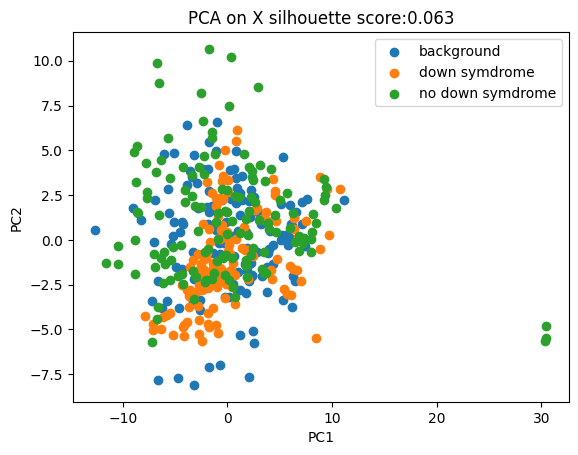

In [41]:
# PCA on foreground
label=np.vstack((np.zeros(Z1.shape[0]),np.ones(Z2.shape[0]))).reshape(-1)
pca=PCA(n_components=2)
X_top2=pca.fit_transform(X)
fig,axs=plt.subplots(1,1)
directions=pca.components_.T
pattern_1=directions[:,0].reshape(1,-1)
pattern_2=directions[:,1].reshape(1,-1)
axs.scatter(pattern_1@Y.T,pattern_2@Y.T,label='background')
axs.scatter(pattern_1@Z1.T,pattern_2@Z1.T,label='down symdrome')
axs.scatter(pattern_1@Z2.T,pattern_2@Z2.T,label='no down symdrome')
axs.legend()
axs.set_xlabel('PC1')
axs.set_ylabel('PC2')
sil_score=silhouette_score(X_top2,label)
axs.set_title('PCA on X'+' '+'silhouette score:'+f'{sil_score:0.3f}')
print(Kmeans_based_score(X,directions,label))
print(SVC_based_score(X,directions,label))

Text(0, 0.5, 'eigenvalue')

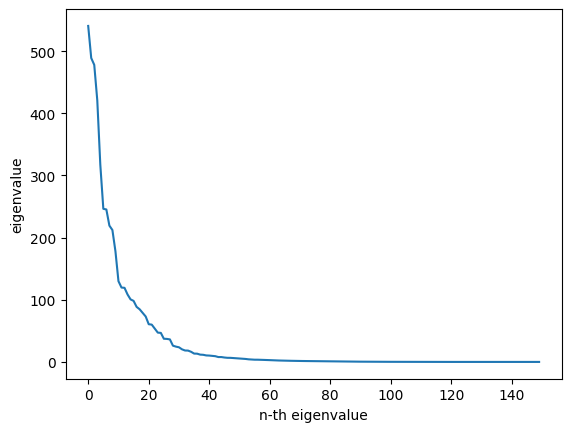

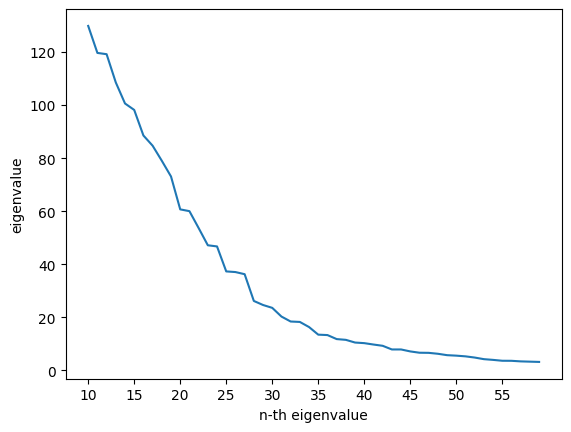

In [4]:
#cICA choices of r
I=k4_b.shape[0]
D,V=eig2(k4_b.reshape(I**2,I**2))
plt.plot(range(150),abs(D)[:150])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')
plt.figure()
plt.plot(range(10,60),abs(D)[10:60])
plt.xticks(range(10,60,5))
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')

Text(0, 0.5, 'eigenvalue')

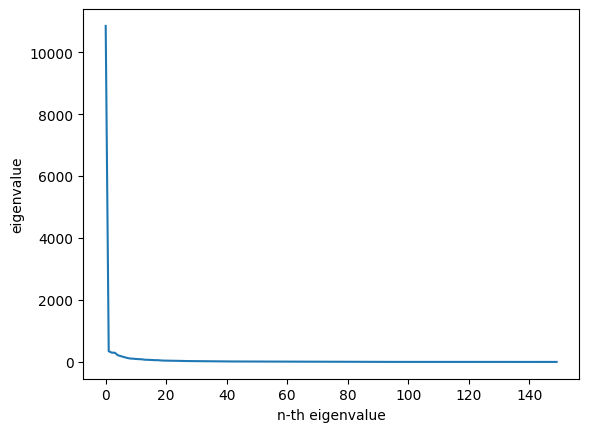

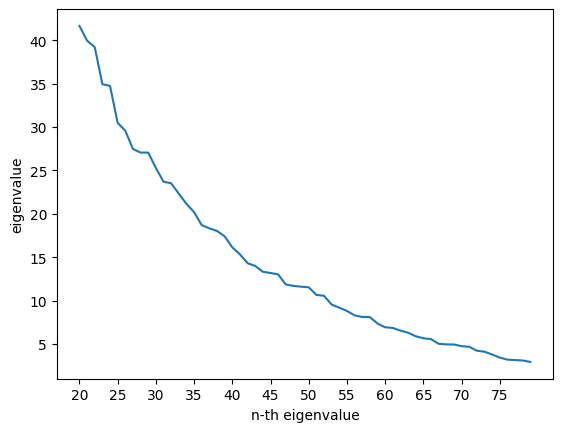

In [5]:
#cICA choices of r+\ell
I=k4_f.shape[0]
D,V=eig2(k4_f.reshape(I**2,I**2))
plt.plot(range(150),abs(D)[:150])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')
plt.figure()
plt.plot(range(20,80),abs(D)[20:80])
plt.xticks(range(20,80,5))
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')

-0.12088424726482967


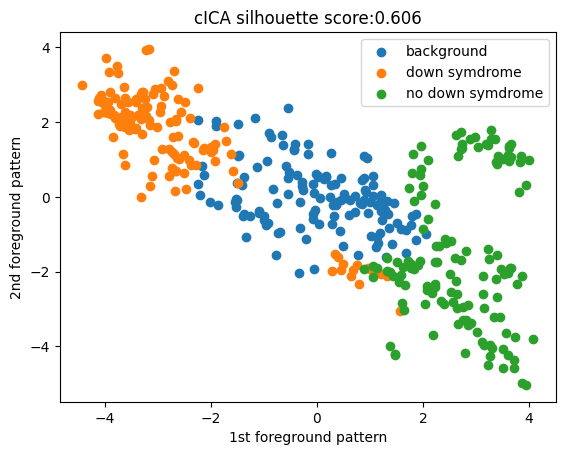

In [122]:
#cICA r=27 l=26
np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residule,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=27,l=26)
plot_graph_mice(b_s_sorted[:,:2],'1st foreground pattern','2nd foreground pattern','cICA',mice_silhouette(b_s_sorted[:,:2]))
print((b_s_sorted[:,0]@ a_s)@(b_s_sorted[:,1]@ a_s))
np.save('mice_b',b_s_sorted)

/Users/kexinwang/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.01682767064184445, 0.01896588157181663)
(0.9127621867926321, 0.8480227537391418)


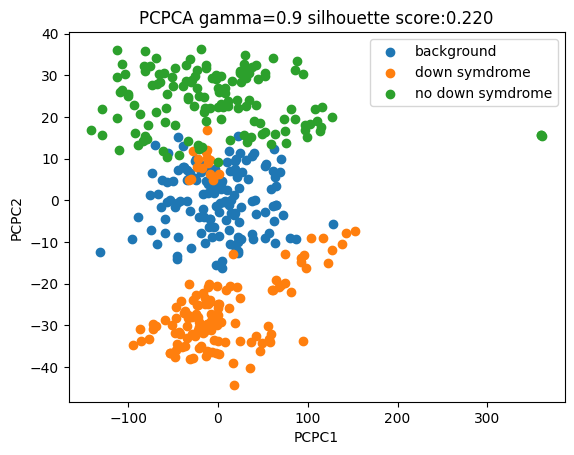

In [519]:
#PCPCA on whole datasets
silhouette_score_list=[]
b_list=[]
n, m = X.shape[0], Y.shape[0]
for gamma in np.linspace(0,0.9,100):
    pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
    X_reduced,Y_reduced=pcpca.fit_transform(X.T,Y.T)
    b=pcpca.W_mle
    # b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
    silhouette_score_list.append(mice_silhouette_whole_dataset(b))
    b_list.append(b)
index=np.argmax(np.array(silhouette_score_list))
gamma=np.linspace(0,0.9,100)[index]
plot_graph_mice_wholedataset(b_list[index],'PCPC1','PCPC2',f'PCPCA gamma={gamma}',silhouette_score_list[index])
directions=b_list[index]
print(Kmeans_based_score(X,directions,label))
print(SVC_based_score(X,directions,label))


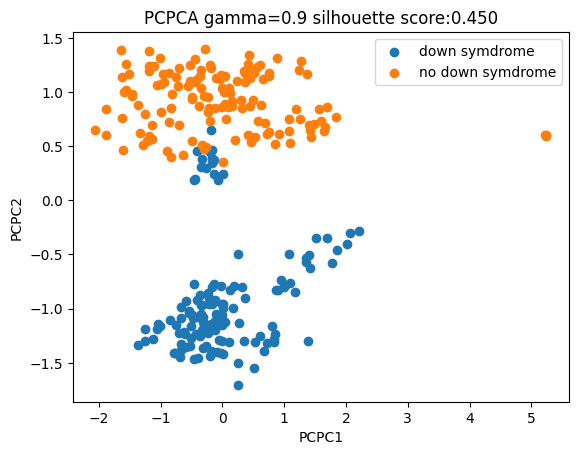

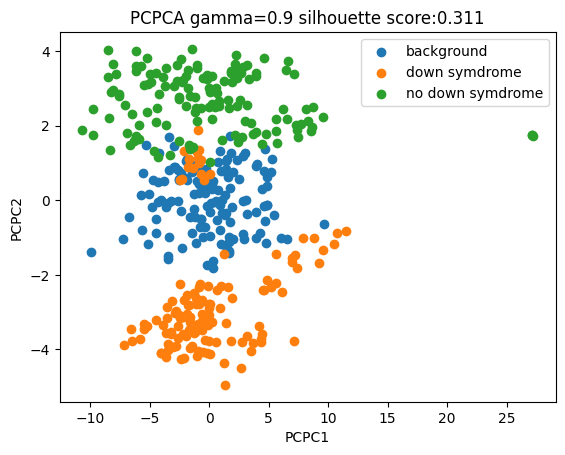

In [529]:
#PCPCA whole dataset
# normlize X,Y
gamma=0.9
n,m=X.shape[0],Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
X_reduced,Y_reduced=pcpca.fit_transform(X.T,Y.T)
X_reduced = (X_reduced.T / X_reduced.T.std(0)).T
# Y_reduced = (Y_reduced.T / X_reduced.T.std(0)).T
fig,axs=plt.subplots(1,1)
# axs.scatter(Y_reduced[0,:].T,Y_reduced[1,:].T,label='background')
axs.scatter(X_reduced[0,:135].T,X_reduced[1,:135].T,label='down symdrome')
axs.scatter(X_reduced[0,135:].T,X_reduced[1,135:].T,label='no down symdrome')
axs.legend()
axs.set_xlabel('PCPC1')
axs.set_ylabel('PCPC2')
sil_score=silhouette_score(X_reduced.T,label)
axs.set_title('PCPCA'+f' gamma={gamma}'+' '+'silhouette score:'+f'{sil_score:0.3f}')

# normalize b
n,m=X.shape[0],Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
pcpca.fit(X.T,Y.T)
b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
plot_graph_mice_wholedataset(b,'PCPC1','PCPC2',f'PCPCA gamma={gamma}',mice_silhouette_whole_dataset(b))


[  0.          29.15053063 327.45491629 911.16275612]
(0.7893500391542678, 0.7427610701225345)
(0.7893500391542678, 0.7427610701225345)


/Users/kexinwang/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


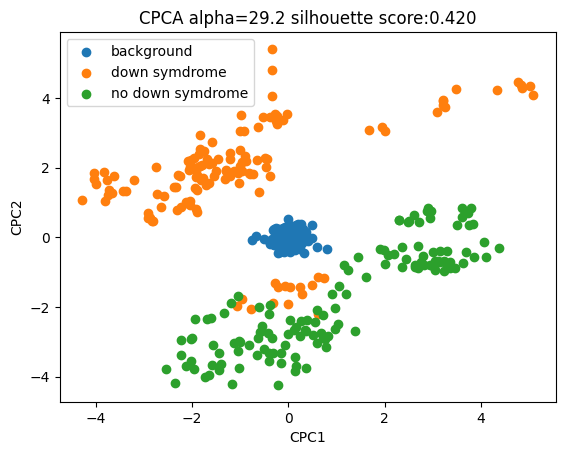

In [177]:
#CPCA whole dataset
mdl=CPCA()
silhouette_score_list=[]
label=np.hstack((np.zeros(Z1.shape[0]),np.ones(Z2.shape[0])))
l,alphas=mdl.fit_transform(X,Y,active_labels=label,n_alphas=100,return_alphas=True,max_log_alpha=3)
print(alphas)
for array in l:
    silhouette_score_list.append(silhouette_score(array,label))
index=np.argmax(silhouette_score_list)
alpha=alphas[index]
# alpha=251.38
D,V=np.linalg.eig(mdl.fg_cov-alpha*mdl.bg_cov)
eig_idx = np.argpartition(D, -2)[-2:]
b_cpca=V[:,eig_idx]
plot_graph_mice_wholedataset(b_cpca,'cPC1','cPC2',f'cPCA alpha={alpha:0.1f}',mice_silhouette_whole_dataset(b_cpca))
directions=b_cpca
print(Kmeans_based_score(X,directions,label))
print(SVC_based_score(X,directions,label))

0.7305271542664452
(0.7501897861865138, 0.6676979750881032)


/Users/kexinwang/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.9414008628455559, 0.8915072540920427)


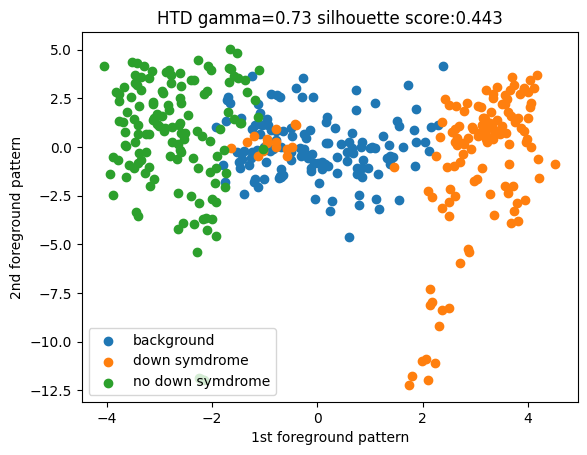

In [178]:
# hierachical tensor decomp of k4_f-gamma k4_b
sil_score=[]
for gamma in np.logspace(-3,3,num=100): 
    gamma=np.sqrt(gamma)
    b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,26)
    sil_score.append(mice_silhouette(b_s_sorted[:,:2]))
index=np.argmax(np.array(sil_score))
gamma=np.sqrt(np.logspace(-3,2,num=100))[index]
print(gamma)
b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,26)
plot_graph_mice(b_s_sorted[:,:2],'1st foreground pattern','2nd foreground pattern',f'HTD gamma={gamma:0.2f}',mice_silhouette(b_s_sorted[:,:2]))
directions=b_s_sorted[:,:2]
print(Kmeans_based_score(X_pca,directions,label))
print(SVC_based_score(X_pca,directions,label))

# Corrupted MNIST digits 0,1

In [ ]:
# grass images are downloaded from imagenet with id n12102133
import keras
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
index=np.where(y_train<2)[0]
foreground=X_train[index][:5000]
target_labels = y_train[index][:5000]


from PIL import Image
from resizeimage import resizeimage
import os

IMAGE_PATH = 'n12102133/' #Replace with your own path to downloaded images
        
natural_images = list() #dictionary of pictures indexed by the pic # and each value is 100x100 image
num=0
for filename in os.listdir(IMAGE_PATH):
    num+=1
    if filename.endswith(".JPEG") or filename.endswith(".JPG") or filename.endswith(".jpg"):
        try:
            im = Image.open(os.path.join(IMAGE_PATH,filename))
            im = im.convert(mode="L") #convert to grayscale

            im = resizeimage.resize_crop(im,[100,100]) #resize and crop each picture to be 100px by 100px
            natural_images.append(np.reshape(im, [10000])) 
        except Exception as e:
            pass #print(e)
            
natural_images=np.asarray(natural_images,dtype=float)
natural_images/=255 #rescale to be 0-1
print("Array of grass images:",natural_images.shape)

# Corrupt the MNIST digits with the grass
from tqdm import tqdm

np.random.seed(0)  # for reproducibility

rand_indices = np.random.permutation(
    natural_images.shape[0]
)  # just shuffles the indices
split = int(len(rand_indices) / 2)
target_indices = rand_indices[
    0:split
]  # choose the first half of images to be superimposed on target
background_indices = rand_indices[
    split:
]  # choose the second half of images to be background dataset

target = np.zeros((foreground.shape[0],28**2))
background = np.zeros((foreground.shape[0],28**2))

print("Corrupting MNIST with grass...")
for i in range(target.shape[0]):
    idx = np.random.choice(target_indices) # randomly pick a image 
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    superimposed_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784]) 
    foregroundreshaped=foreground[i].reshape(1,-1)
    target[i] = 0.25* foregroundreshaped/255+ superimposed_patch
    
    idx = np.random.choice(background_indices) # randomly pick a image 
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    background_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
    background[i] = background_patch

np.save("./corrupted_mnist/X.npy", target)
np.save("./corrupted_mnist/Y.npy", background)
np.save("./corrupted_mnist/label.npy", target_labels)

# logreg = LogisticRegression()
# logreg.fit(target[:4000], target_labels[:4000])
# train_acc = logreg.score(target[4000:], target_labels[4000:])
# print("Train accuracy: {}".format(round(train_acc, 3)))

n_show = 6

plt.figure(figsize=[21, 7])
for i in range(n_show):
    plt.subplot(2, n_show, i + 1)
    idx = np.random.randint(5000)
    plt.imshow(
        np.reshape(target[idx, :], [28, 28]), cmap="gray", interpolation="bicubic"
    )
    plt.axis("off")

for i in range(n_show):
    plt.subplot(2, n_show, n_show + i + 1)
    idx = np.random.randint(5000)
    plt.imshow(
        np.reshape(background[idx, :], [28, 28]), cmap="gray", interpolation="bicubic"
    )
    plt.axis("off")
plt.show()
# import ipdb; ipdb.set_trace()

In [183]:
X=np.load("./corrupted_mnist/foreground.npy")
Y=np.load("./corrupted_mnist/background.npy")
label=np.load("./corrupted_mnist/foreground_labels.npy")

# 15 components explain 74.5% covariance
# 20 components explain 76% covariance
pca=PCA(n_components=30)
pca.fit(np.vstack((X,Y)))
print(np.cumsum(pca.explained_variance_ratio_))

index_0=np.where(label==0)
index_1=np.where(label==1)
label=np.hstack((np.zeros(X[index_0].shape[0]),np.ones(X[index_1].shape[0])))
X_0=X[index_0]
X_1=X[index_1]
X=np.vstack((X[index_0],X[index_1]))
X_pca_0=pca.transform(X_0)
X_pca_1=pca.transform(X_1)
Y_pca=pca.transform(Y)
X_pca=pca.transform(X)

# k2_f,k4_f=cumulant_tensors(X_pca)
# k2_b,k4_b=cumulant_tensors(Y_pca)
# np.save('corrupted_mnist/k2_b_01',k2_b)
# np.save('corrupted_mnist/k2_f_01',k2_f)
# np.save('corrupted_mnist/k4_b_01',k4_b)
# np.save('corrupted_mnist/k4_f_01',k4_f)


k4_f=np.load('corrupted_mnist/k4_f_01.npy')
k4_b=np.load('corrupted_mnist/k4_b_01.npy')
k2_f=np.load('corrupted_mnist/k2_f_01.npy')
k2_b=np.load('corrupted_mnist/k2_b_01.npy')

def plot_graph_mnist01(directions,xlabel,ylabel,title,sil_score):
    fig,axs=plt.subplots(1,1)
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    # axs[i,j].scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,color='b',label='background')
    axs.scatter(pattern_1@X_pca_0.T,pattern_2@X_pca_0.T,label='digit 0')
    axs.scatter(pattern_1@X_pca_1.T,pattern_2@X_pca_1.T,label='digit 1')
    axs.legend()
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')

def mnist_silhouette(directions):
    pattern_1=directions[:,0]
    pattern_2=directions[:,1]
    cluster_1=np.vstack((pattern_1@X_pca_0.T,pattern_2@X_pca_0.T))
    cluster_2=np.vstack((pattern_1@X_pca_1.T,pattern_2@X_pca_1.T))
    cluster_label=np.hstack((np.zeros(cluster_1.shape[1]),np.ones(cluster_2.shape[1])))
    cluster=np.hstack((cluster_1,cluster_2))
    return silhouette_score(cluster.T,cluster_label)

def plot_graph_mnist01_wholedataset(directions,xlabel,ylabel,title,sil_score):
    fig,axs=plt.subplots(1,1)
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    # axs[i,j].scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,color='b',label='background')
    axs.scatter(pattern_1@X_0.T,pattern_2@X_0.T,label='digit 0')
    axs.scatter(pattern_1@X_1.T,pattern_2@X_1.T,label='digit 1')
    axs.legend()
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')

def mnist_silhouette_wholedataset(directions):
    pattern_1=directions[:,0]
    pattern_2=directions[:,1]
    cluster_1=np.vstack((pattern_1@X_0.T,pattern_2@X_0.T))
    cluster_2=np.vstack((pattern_1@X_1.T,pattern_2@X_1.T))
    cluster_label=np.hstack((np.zeros(cluster_1.shape[1]),np.ones(cluster_2.shape[1])))
    cluster=np.hstack((cluster_1,cluster_2))
    return silhouette_score(cluster.T,cluster_label)

[0.53485328 0.58937462 0.63044069 0.65464145 0.67119304 0.68670367
 0.69935187 0.70833134 0.71693592 0.72510265 0.73217841 0.73862362
 0.74446349 0.74944595 0.75424835 0.75867041 0.76290632 0.76669556
 0.77030768 0.77374533 0.77711897 0.78032244 0.78334603 0.78619263
 0.78891371 0.79147658 0.79396915 0.79631211 0.79861538 0.80084499]


In [6]:
k4_f=np.load('corrupted_mnist/k4_f_01.npy')
k4_b=np.load('corrupted_mnist/k4_b_01.npy')
k2_f=np.load('corrupted_mnist/k2_f_01.npy')
k2_b=np.load('corrupted_mnist/k2_b_01.npy')

Text(0.5, 1.0, 'PCA on X silhouette score:0.003')

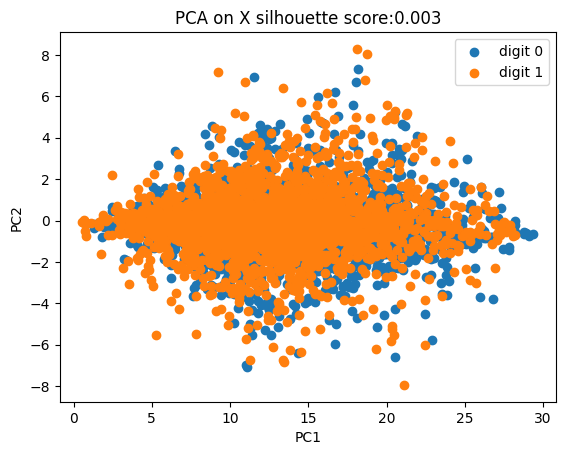

In [113]:
# PCA on foreground
pca=PCA(n_components=2)
X_top2_mnist=pca.fit_transform(X)
fig,axs=plt.subplots(1,1)
directions=pca.components_.T
pattern_1=directions[:,0].reshape(1,-1)
pattern_2=directions[:,1].reshape(1,-1)

axs.scatter(pattern_1@X_0.T,pattern_2@X_0.T,label='digit 0')
axs.scatter(pattern_1@X_1.T,pattern_2@X_1.T,label='digit 1')
axs.legend()
axs.set_xlabel('PC1')
axs.set_ylabel('PC2')
sil_score=silhouette_score(X_top2_mnist,label)
axs.set_title('PCA on X'+' '+'silhouette score:'+f'{sil_score:0.3f}')

Text(0.5, 0, 'n-th eigenvalue')

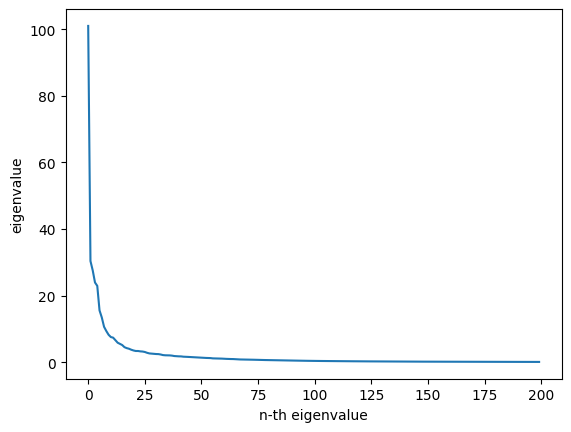

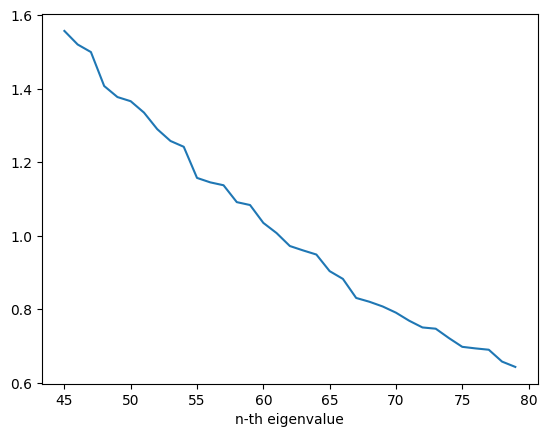

In [7]:
#cICA choices of r
I=k4_b.shape[0]
D,V=eig2(k4_b.reshape(I**2,I**2))
plt.plot(range(200),abs(D)[:200])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')
plt.figure()
plt.plot(range(45,80),abs(D)[45:80])
plt.xlabel('n-th eigenvalue')



Text(0, 0.5, 'eigenvalue')

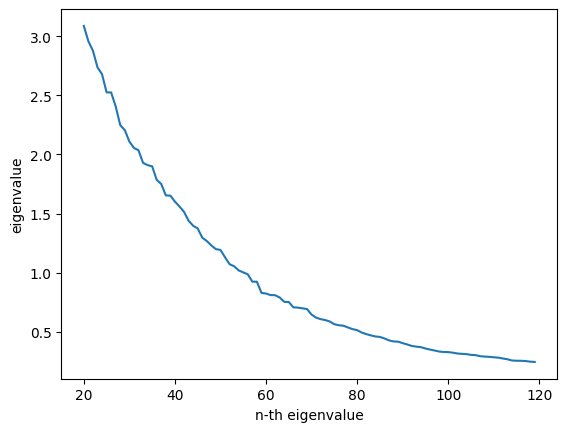

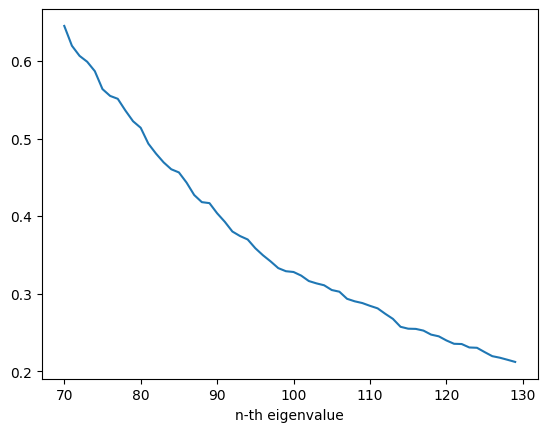

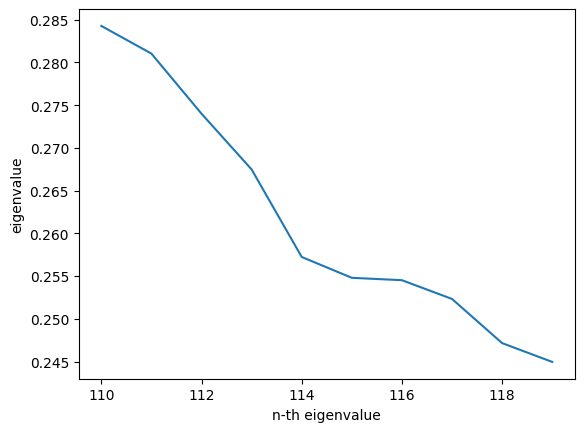

In [145]:
#cICA choices of r+\ell
I=k4_f.shape[0]
D,V=eig2(k4_f.reshape(I**2,I**2))
plt.plot(range(20,120),abs(D)[20:120])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')
plt.figure()
plt.plot(range(70,130),abs(D)[70:130])
plt.xlabel('n-th eigenvalue')
plt.figure()
plt.plot(range(110,120),abs(D)[110:120])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')


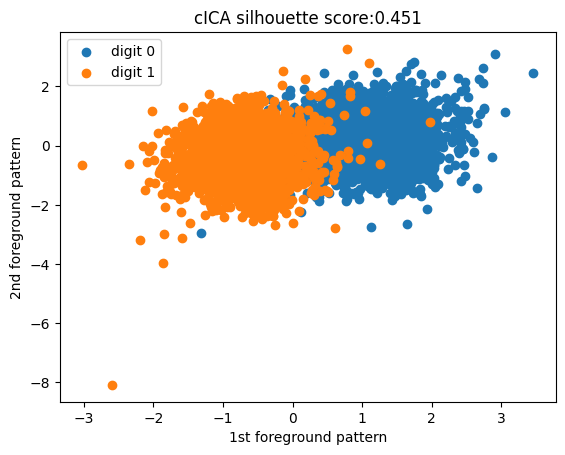

In [184]:
#cICA r=53, l=61
np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residual,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=53,l=61)
plot_graph_mnist01(b_s_sorted[:,:2],'1st foreground pattern','2nd foreground pattern','cICA',mnist_silhouette(b_s_sorted[:,:2]))

/Users/kexinwang/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.004635081151699525, 0.0031952645022341)
(0.8641262602679821, 0.7795575400405182)


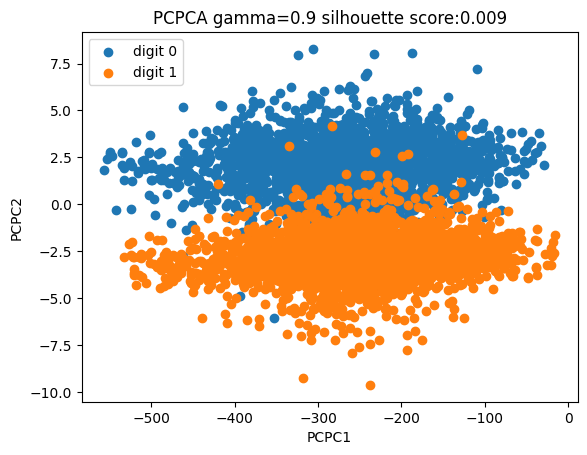

In [515]:
#PCPCA on whole dataset 
silhouette_score_list=[]
b_list=[]
n, m = X.shape[0], Y.shape[0]
for gamma in np.linspace(0,0.9,100):
    pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
    X_reduced,Y_reduced=pcpca.fit_transform(X.T,Y.T)
    b=pcpca.W_mle
    # b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
    silhouette_score_list.append(mnist_silhouette_wholedataset(b))
    b_list.append(b)
index=np.argmax(np.array(silhouette_score_list))
gamma=np.linspace(0,0.9,100)[index]

plot_graph_mnist01_wholedataset(b_list[index],'PCPC1','PCPC2',f'PCPCA gamma={gamma}',silhouette_score_list[index])

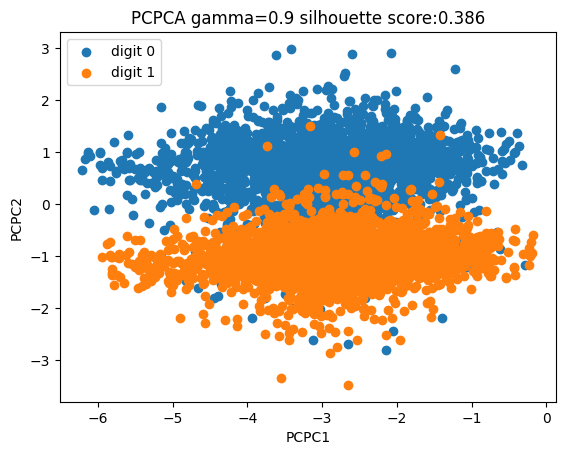

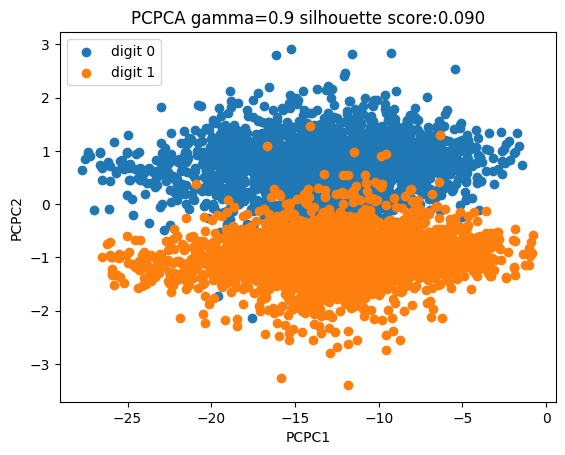

In [537]:
#PCPCA whole dataset
# normlize X,Y
gamma=0.9
n,m=X.shape[0],Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
X_reduced,Y_reduced=pcpca.fit_transform(X.T,Y.T)
X_reduced = (X_reduced.T / X_reduced.T.std(0)).T
# Y_reduced = (Y_reduced.T / X_reduced.T.std(0)).T
fig,axs=plt.subplots(1,1)
# axs.scatter(Y_reduced[0,:].T,Y_reduced[1,:].T,label='background')
axs.scatter(X_reduced[0,:2500].T,X_reduced[1,:2500].T,label='digit 0')
axs.scatter(X_reduced[0,2500:].T,X_reduced[1,2500:].T,label='digit 1')
axs.legend()
axs.set_xlabel('PCPC1')
axs.set_ylabel('PCPC2')
sil_score=silhouette_score(X_reduced.T,label)
axs.set_title('PCPCA'+f' gamma={gamma}'+' '+'silhouette score:'+f'{sil_score:0.3f}')

# normalize b
n,m=X.shape[0],Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
pcpca.fit(X.T,Y.T)
b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
plot_graph_mnist01_wholedataset(b,'PCPC1','PCPC2',f'PCPCA gamma={gamma}',mnist_silhouette_wholedataset(b))

/Users/kexinwang/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.869338652908592, 0.7898475360376582)
(0.8783166658108702, 0.7982751347576258)


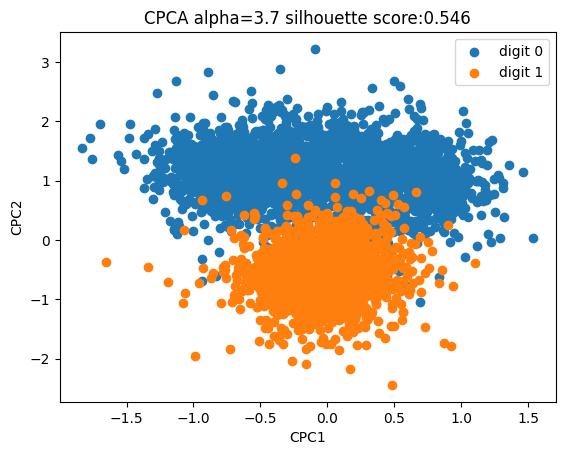

In [67]:
#CPCA whole dataset
mdl=CPCA()
silhouette_score_list=[]
l,alphas=mdl.fit_transform(X,Y,active_labels=label,n_alphas=200,return_alphas=True,max_log_alpha=3)
for array in l:
    silhouette_score_list.append(silhouette_score(array,label))
index=np.argmax(np.array(silhouette_score_list))
alpha=alphas[index]
D,V=np.linalg.eig(mdl.fg_cov-alpha*mdl.bg_cov)
eig_idx = np.argpartition(D, -2)[-2:]
b_cpca=V[:,eig_idx]
plot_graph_mnist01_wholedataset(b_cpca,'cPC1','cPC2',f'cPCA alpha={alpha:0.1f}',silhouette_score_list[index])
directions=b_cpca
print(Kmeans_based_score(X,directions,label))
print(SVC_based_score(X,directions,label))

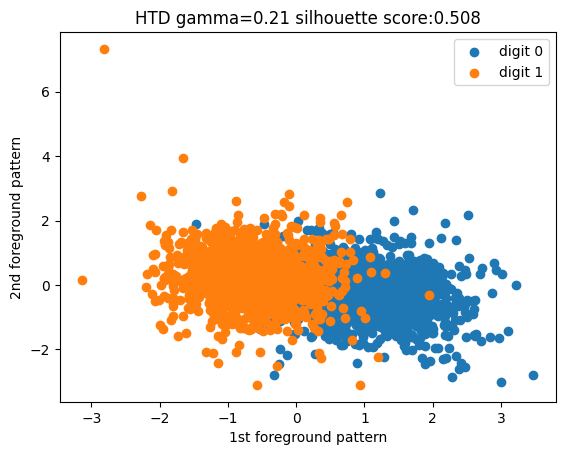

In [189]:
# hierachical tensor decomp of k4_f-gamma k4_b
sil_score=[]
for gamma in np.sqrt(np.logspace(-3,3,num=100)): 
    b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,61)
    sil_score.append(mnist_silhouette(b_s_sorted[:,:2]))
index=np.argmax(np.array(sil_score))
gamma=np.sqrt(np.logspace(-3,3,num=100))[index]
b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,61)
plot_graph_mnist01(b_s_sorted[:,:2],'1st foreground pattern','2nd foreground pattern',f'HTD gamma={gamma:0.2f}',mnist_silhouette(b_s_sorted[:,:2]))

# Single-cell RNA data

In [ ]:
# data downloaded from https://www.10xgenomics.com/datasets/frozen-bmm-cs-healthy-control-2-1-standard-1-1-0
fnames = ['293t',           #0
          'aml027_post',    #1
          'aml027_pre',     #2
          'aml035_post',    #3
          'aml035_pre',     #4
          'b',              #5
          'bmmc_healthy_1', #6
          'bmmc_healthy_2', #7
         ] 

DATA_DIR = 'single_cell_RNA_data_files/'
N_GENES = 500


def get_data_df(subdata_dir):
    data = mmread(pjoin(DATA_DIR, subdata_dir, "hg19/matrix.mtx")).toarray()
    data = np.log(data + 1)
    genes = pd.read_table(pjoin(DATA_DIR, subdata_dir, "hg19/genes.tsv"), header=None)
    barcodes = pd.read_table(
        pjoin(DATA_DIR, subdata_dir, "hg19/barcodes.tsv"), header=None
    )
    data_df = pd.DataFrame(
        data, index=genes.iloc[:, 0].values, columns=barcodes.iloc[:, 0].values
    )

    data_df = data_df.iloc[:, np.sum(data_df.values, axis=0) != 0]
    data_df = data_df.iloc[np.sum(data_df.values, axis=1) != 0, :]
    return data_df.transpose()


## Load all data
pretransplant1 = get_data_df("aml027_pre")
posttransplant1 = get_data_df("aml027_post")
pretransplant2 = get_data_df("aml035_pre")
posttransplant2 = get_data_df("aml035_post")

healthy1 = get_data_df("bmmc_healthy_1")
healthy2 = get_data_df("bmmc_healthy_2")

shared_genes = pretransplant1.columns.values
for curr_df in [posttransplant1, pretransplant2, posttransplant2, healthy1, healthy2]:
    shared_genes = np.intersect1d(shared_genes, curr_df.columns.values)

stacked_df = pretransplant1[shared_genes]
for curr_df in [
    posttransplant1,
    pretransplant2,
    posttransplant2,
]:  # , healthy1, healthy2]:
    stacked_df = pd.concat([stacked_df, curr_df[shared_genes]], axis=0)
print("Total of {} cells and {} genes".format(stacked_df.shape[0], stacked_df.shape[1]))

gene_means = np.mean(stacked_df.values, axis=0)
gene_vars = np.var(stacked_df.values, axis=0)
gene_dispersions = gene_vars / gene_means
top_idx = np.argsort(-gene_dispersions)[:N_GENES]
top_genes = stacked_df.columns.values[top_idx]

print("Saving {} genes".format(top_genes.shape[0]))

pretransplant1[top_genes].to_csv(pjoin(DATA_DIR, "clean", "pretransplant1.csv"))
posttransplant1[top_genes].to_csv(pjoin(DATA_DIR, "clean", "posttransplant1.csv"))

pretransplant2[top_genes].to_csv(pjoin(DATA_DIR, "clean", "pretransplant2.csv"))
posttransplant2[top_genes].to_csv(pjoin(DATA_DIR, "clean", "posttransplant2.csv"))

healthy1[top_genes].to_csv(pjoin(DATA_DIR, "clean", "healthy1.csv"))
healthy2[top_genes].to_csv(pjoin(DATA_DIR, "clean", "healthy2.csv"))

In [190]:
# Background is made up of healthy cells
DATA_DIR = 'single_cell_RNA_data_files/'
pretransplant2 = pd.read_csv(pjoin(DATA_DIR, "clean", "pretransplant2.csv"), index_col=0)
pretransplant1= pd.read_csv(pjoin(DATA_DIR, "clean", "pretransplant1.csv"), index_col=0)
posttransplant2 = pd.read_csv(pjoin(DATA_DIR, "clean", "posttransplant2.csv"), index_col=0)
posttransplant1=pd.read_csv(pjoin(DATA_DIR, "clean", "posttransplant1.csv"), index_col=0)

healthy1 = pd.read_csv(pjoin(DATA_DIR, "clean", "healthy1.csv"), index_col=0)
healthy2= pd.read_csv(pjoin(DATA_DIR, "clean", "healthy2.csv"), index_col=0)
Y = pd.concat([healthy1, healthy2], axis=0).values

X = pd.concat([pretransplant2,pretransplant1, posttransplant2,posttransplant1], axis=0).values
X_pre= pd.concat([pretransplant2, pretransplant1], axis=0).values
X_post= pd.concat([posttransplant2,posttransplant1], axis=0).values

# Standardize
Y -= Y.mean(0)
Y /= Y.std(0)
a=X.mean(0)
b=X.std(0)
X -= a
X /= b
X_pre-=a
X_pre/=b
X_post-=a
X_post/=b

n, m = X.shape[1], Y.shape[1]

pca=PCA(n_components=30)
pca.fit(np.vstack((X,Y)))
print(np.cumsum(pca.explained_variance_ratio_))

X_pca_pre=pca.transform(X_pre)
X_pca_post=pca.transform(X_post)
Y_pca=pca.transform(Y)
X_pca=pca.transform(X)
X_pca=np.vstack((X_pca_pre,X_pca_post))

label=np.hstack((np.zeros(X_pca_pre.shape[0]),np.ones(X_pca_post.shape[0])))

# k2_f,k4_f=cumulant_tensors(X_pca)
# k2_b,k4_b=cumulant_tensors(Y_pca)
k2_b=np.load('single_cell_RNA_data_files/k2_b.npy')
k2_f=np.load('single_cell_RNA_data_files/k2_f.npy')
k4_b=np.load('single_cell_RNA_data_files/k4_b.npy')
k4_f=np.load('single_cell_RNA_data_files/k4_f.npy')


def plot_graph_RNA(directions,xlabel,ylabel,title,sil_score):
    fig,axs=plt.subplots(1,1)
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    # axs[i,j].scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,color='b',label='background')
    axs.scatter(pattern_1@X_pca_post.T,pattern_2@X_pca_post.T,label='post-transplant',s=0.8)
    axs.scatter(pattern_1@X_pca_pre.T,pattern_2@X_pca_pre.T,label='pre-transplant',s=0.8)
    
    axs.legend()
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')


def plot_graph_RNA_2(directions,xlabel,ylabel,title,sil_score):
    fig,axs=plt.subplots(1,1)
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    # axs[i,j].scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,color='b',label='background')
    axs.scatter(pattern_1@X_pca_pre.T,pattern_2@X_pca_pre.T,label='pre-transplant',s=0.8)
    axs.scatter(pattern_1@X_pca_post.T,pattern_2@X_pca_post.T,label='post-transplant',s=0.8)
    axs.legend()
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')

def RNA_silhouette(directions):
    pattern_1=directions[:,0]
    pattern_2=directions[:,1]
    cluster_1=np.vstack((pattern_1@X_pca_pre.T,pattern_2@X_pca_pre.T))
    cluster_2=np.vstack((pattern_1@X_pca_post.T,pattern_2@X_pca_post.T))
    cluster_label=np.hstack((np.zeros(cluster_1.shape[1]),np.ones(cluster_2.shape[1])))
    cluster=np.hstack((cluster_1,cluster_2))
    return silhouette_score(cluster.T,cluster_label)

def plot_graph_RNA_wholedataset(directions,xlabel,ylabel,title,sil_score):
    fig,axs=plt.subplots(1,1)
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    # axs[i,j].scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,color='b',label='background')
    axs.scatter(pattern_1@X_post.T,pattern_2@X_post.T,label='post-transplant',s=0.8)
    axs.scatter(pattern_1@X_pre.T,pattern_2@X_pre.T,label='pre-transplant',s=0.8)
    axs.legend()
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')

def plot_graph_RNA_2_wholedataset(directions,xlabel,ylabel,title,sil_score):
    fig,axs=plt.subplots(1,1)
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    # axs[i,j].scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,color='b',label='background')
    axs.scatter(pattern_1@X_pre.T,pattern_2@X_pre.T,label='pre-transplant',s=0.8)
    axs.scatter(pattern_1@X_post.T,pattern_2@X_post.T,label='post-transplant',s=0.8)
    axs.legend()
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')

def RNA_silhouette_wholedataset(directions):
    pattern_1=directions[:,0]
    pattern_2=directions[:,1]
    cluster_1=np.vstack((pattern_1@X_pre.T,pattern_2@X_pre.T))
    cluster_2=np.vstack((pattern_1@X_post.T,pattern_2@X_post.T))
    cluster_label=np.hstack((np.zeros(cluster_1.shape[1]),np.ones(cluster_2.shape[1])))
    cluster=np.hstack((cluster_1,cluster_2))
    return silhouette_score(cluster.T,cluster_label)

[0.19160671 0.29613218 0.33393818 0.36200888 0.38282322 0.40232312
 0.41945093 0.43330493 0.44555631 0.45596845 0.46459935 0.47239533
 0.47941659 0.48571725 0.49194181 0.49715344 0.50222018 0.50705585
 0.51157814 0.51589655 0.52006315 0.52402249 0.52754617 0.53104847
 0.53446949 0.53784316 0.54103726 0.54414491 0.54707841 0.54983995]


Text(0.5, 1.0, 'PCA on X silhouette score:0.107')

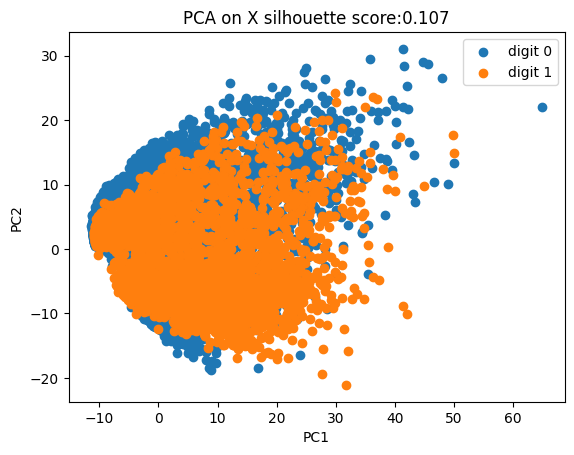

In [172]:
# PCA on foreground
pca=PCA(n_components=2)
X_top2_RNA=pca.fit_transform(X)
fig,axs=plt.subplots(1,1)
directions=pca.components_.T
pattern_1=directions[:,0].reshape(1,-1)
pattern_2=directions[:,1].reshape(1,-1)

axs.scatter(pattern_1@X_pre.T,pattern_2@X_pre.T,label='digit 0')
axs.scatter(pattern_1@X_post.T,pattern_2@X_post.T,label='digit 1')
axs.legend()
axs.set_xlabel('PC1')
axs.set_ylabel('PC2')
sil_score=silhouette_score(X_top2_RNA,label)
axs.set_title('PCA on X'+' '+'silhouette score:'+f'{sil_score:0.3f}')

Text(0, 0.5, 'eigenvalue')

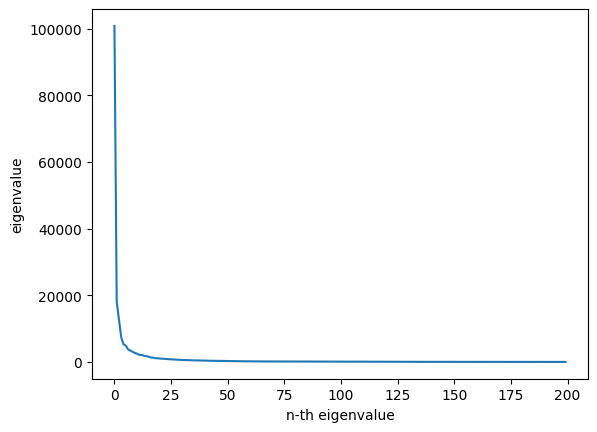

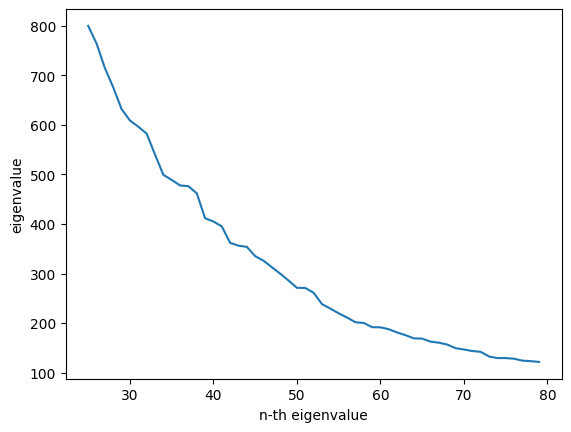

In [9]:
#cICA choices of r
I=k4_b.shape[0]
D,V=eig2(k4_b.reshape(I**2,I**2))
plt.plot(range(200),abs(D)[:200])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')
plt.figure()
plt.plot(range(25,80),abs(D)[25:80])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')

#50-55 seems to be a reasonable choice

Text(0, 0.5, 'eigenvalue')

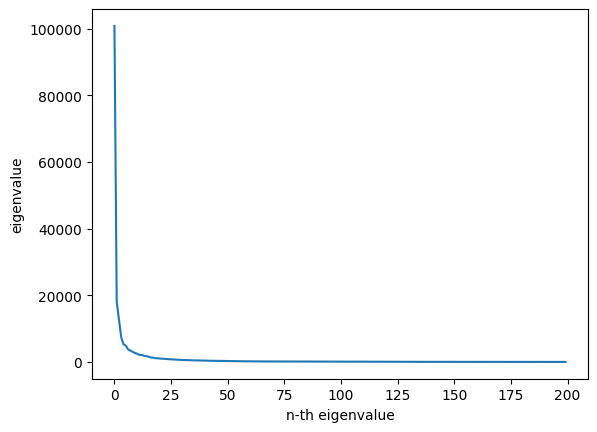

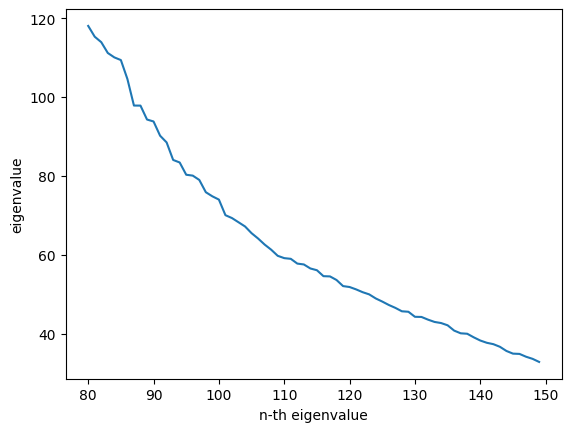

In [10]:
#cICA choice of r+\ell
I=k4_b.shape[0]
D,V=eig2(k4_b.reshape(I**2,I**2))
plt.plot(range(200),abs(D)[:200])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')
plt.figure()
plt.plot(range(80,150),abs(D)[80:150])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')


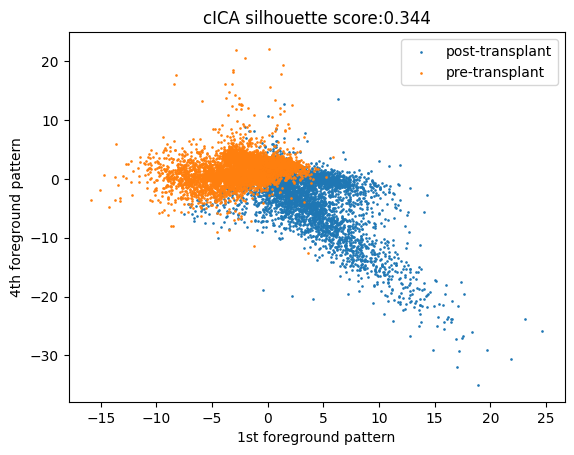

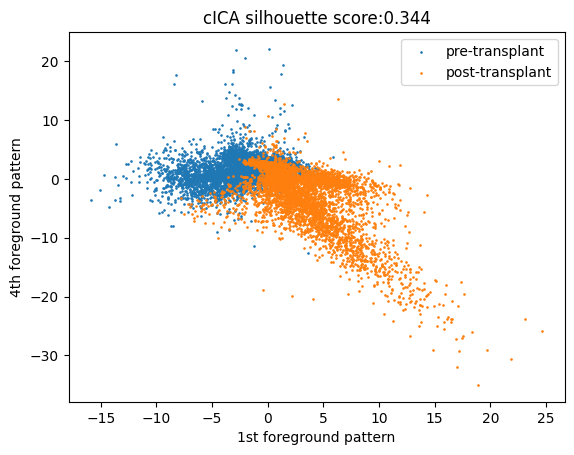

In [161]:
#cICA r=53 l=63
np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residua,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=53,l=63)
plot_graph_RNA(b_s_sorted[:,[0,1]],'1st foreground pattern','4th foreground pattern','cICA',RNA_silhouette(b_s_sorted[:,[0,1]]))
plot_graph_RNA_2(b_s_sorted[:,[0,1]],'1st foreground pattern','4th foreground pattern','cICA',RNA_silhouette(b_s_sorted[:,[0,1]]))


45


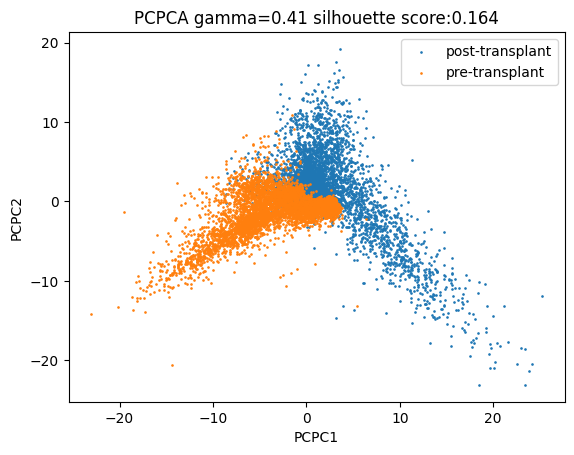

In [12]:
#PCPCA on whole dataset 
silhouette_score_list=[]
b_list=[]
n= X.shape[0]
m=Y.shape[0]
for gamma in np.linspace(0,0.9,100):
    pcpca = PCPCA(gamma=n/m*gamma, n_components=4)
    pcpca.fit(X.T,Y.T)
    b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
    silhouette_score_list.append(RNA_silhouette_wholedataset(b[:,[2,3]]))
    b_list.append(b)
index=np.argmax(np.array(silhouette_score_list))
gamma=np.linspace(0,0.9,100)[index]
print(index)
plot_graph_RNA_wholedataset(b_list[index][:,[2,3]],'PCPC1','PCPC2',f'PCPCA gamma={gamma:0.2f}',silhouette_score_list[index])
directions=b_list[index]
# print(Kmeans_based_score(X,directions,label))
# print(SVC_based_score(X,directions,label))

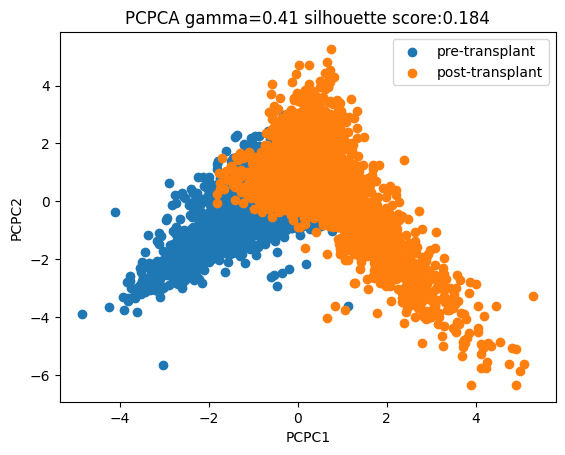

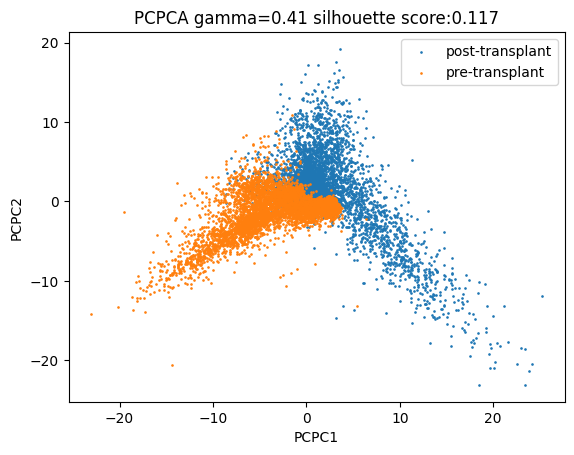

In [24]:
index=45
gamma=np.linspace(0,0.9,100)[index]

#PCPCA whole dataset
# normlize X,Y
pcpca = PCPCA(gamma=n/m*gamma, n_components=4)
X_reduced,Y_reduced=pcpca.fit_transform(X.T,Y.T)
X_reduced = (X_reduced.T / X_reduced.T.std(0)).T
# Y_reduced = (Y_reduced.T / X_reduced.T.std(0)).T
fig,axs=plt.subplots(1,1)
# axs.scatter(Y_reduced[0,:].T,Y_reduced[1,:].T,label='background')
axs.scatter(X_reduced[2,:7525].T,X_reduced[3,:7525].T,label='pre-transplant')
axs.scatter(X_reduced[2,7525:].T,X_reduced[3,7525:].T,label='post-transplant')
axs.legend()
axs.set_xlabel('PCPC1')
axs.set_ylabel('PCPC2')
sil_score=silhouette_score(X_reduced[[2,3],:].T,label)
axs.set_title('PCPCA'+f' gamma={gamma:0.2f}'+' '+'silhouette score:'+f'{sil_score:0.3f}')

# normalize b
n,m=X.shape[0],Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=4)
pcpca.fit(X.T,Y.T)
b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
plot_graph_RNA_wholedataset(b[:,[2,3]],'PCPC1','PCPC2',f'PCPCA gamma={gamma:0.2f}',RNA_silhouette_wholedataset(b))

/Users/kexinwang/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.26698982529287046, 0.30878385560848265)
(0.7751764157749115, 0.6828413115129028)


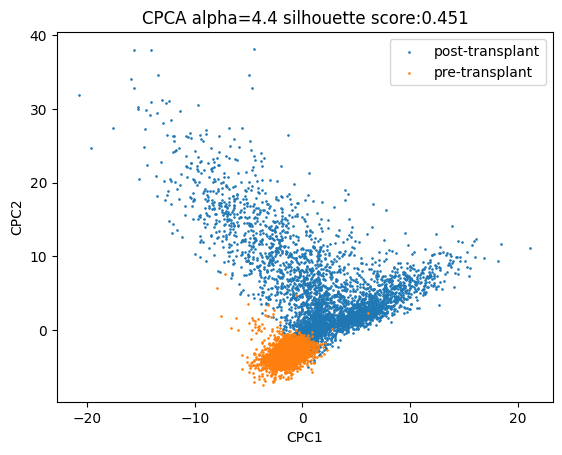

In [191]:
#CPCA whole dataset
mdl=CPCA()
silhouette_score_list=[]
l,alphas=mdl.fit_transform(X,Y,active_labels=label,n_alphas=200,return_alphas=True,max_log_alpha=3)
label=np.hstack((np.zeros(X_pre.shape[0]),np.ones(X_post.shape[0])))
for array in l:
    silhouette_score_list.append(silhouette_score(array,label))
index=np.argmax(np.array(silhouette_score_list))
alpha=alphas[index]
D,V=np.linalg.eig(mdl.fg_cov-alpha*mdl.bg_cov)
eig_idx = np.argpartition(D, -2)[-2:]
b_cpca=V[:,eig_idx]
plot_graph_RNA_wholedataset(b_cpca,'CPC1','CPC2',f'CPCA alpha={alpha:0.1f}',silhouette_score_list[index])
directions=b_cpca
print(Kmeans_based_score(X,directions,label))
print(SVC_based_score(X,directions,label))



/Users/kexinwang/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.27823932716812955, 0.31710727722642146)
(0.7561650361518077, 0.6593141910616457)


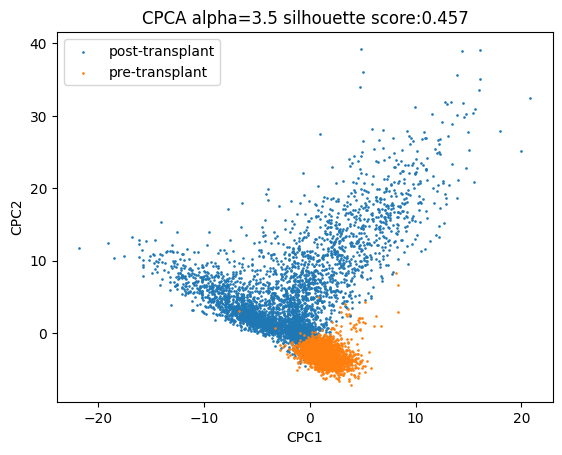

In [227]:
#CPCA whole dataset
alpha=3.5
mdl=CPCA()
mdl.fit(X,Y)
D,V=np.linalg.eig(mdl.fg_cov-alpha*mdl.bg_cov)
eig_idx = np.argpartition(D, -2)[-2:]
b_cpca=V[:,eig_idx]
plot_graph_RNA_wholedataset(b_cpca,'CPC1','CPC2',f'CPCA alpha={alpha:0.1f}',RNA_silhouette_wholedataset(b_cpca))
directions=b_cpca
print(Kmeans_based_score(X,directions,label))
print(SVC_based_score(X,directions,label))

39


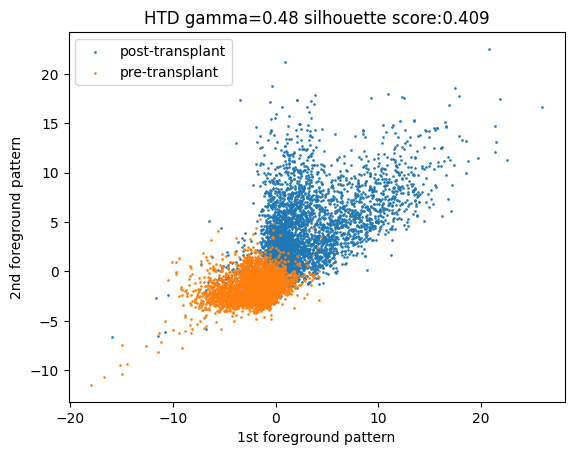

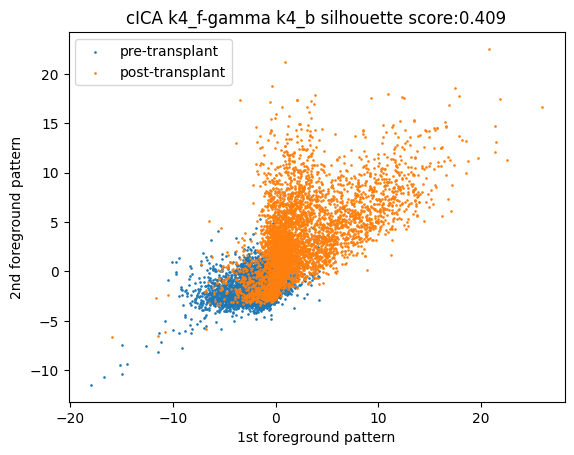

In [194]:
# hierachical tensor decomp of k4_f-gamma k4_b
sil_score=[]
for gamma in np.sqrt(np.logspace(-3,3,num=100)): 
    b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,63)
    sil_score.append(RNA_silhouette(b_s_sorted[:,:2]))
index=np.argmax(np.array(sil_score))
gamma=np.sqrt(np.logspace(-3,3,num=100))[index]
print(index)
b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,63)
plot_graph_RNA(b_s_sorted[:,:2],'1st foreground pattern','2nd foreground pattern',f'HTD gamma={gamma:0.2f}',RNA_silhouette(b_s_sorted[:,:2]))
plot_graph_RNA_2(b_s_sorted[:,:2],'1st foreground pattern','2nd foreground pattern','cICA k4_f-gamma k4_b',RNA_silhouette(b_s_sorted[:,:2]))

# Interpretablity

# non-proportional setting

In [ ]:
# #cICA on synthetic data
np.random.seed()
for n in range(4,13):
    matrix=np.random.rand(n,n)
    Q,r=np.linalg.qr(matrix)
    # np.save(f'toy_example/Q_{n}_{n}',Q)
    B=Q[:,1:]
    A=np.random.randn(n,n)
    A=A/np.linalg.norm(A,axis=0)
    # np.save(f'toy_example/A_{n}_{n}',A)

    # Q=np.load(f'toy_example/Q_{n}_{n}.npy')
    # B=Q[:,1:]
    # A=np.load(f'toy_example/A_{n}_{n}.npy')
    scale=[2,1]*n
    scale_2=[1,2]*n
    n_samples=100000
    y=np.zeros((n-1,n_samples))
    scale_3=[2,1.5]*n
    for i in range(n-1):
        y[i,:]=np.random.exponential(scale_3[i],size=n_samples)
    x_1=np.zeros((n,n_samples))
    x_2=np.zeros((n,n_samples))
    for i in range(n):
        x_1[i,:]=np.random.exponential(scale=scale[i],size=n_samples)
        x_2[i,:]=np.random.exponential(scale=scale_2[i],size=n_samples)
    X=A@x_2+B@y
    Y=A@x_1
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    # np.save(f'toy_example/X_{n}',X)
    # np.save(f'toy_example/Y_{n}',Y)
    cosine_list=[]
    rel_frob_list=[]
    for i in range(100):
            a_s,b_s_sorted,coeff,first_residual,second_residual,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=30,r=n,l=n-1)
            cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_s_sorted,B)
            cosine_list.append(cosine_sim_list)
            rel_frob_list.append(relfroberror)
    # np.save(f'toy_example/cosine_list_{n}',np.array(cosine_list))
    # np.save(f'toy_example/rel_frob_list_{n}',np.array(rel_frob_list))

In [ ]:
for n in range(4,13):
    X=np.load(f'toy_example/X_{n}.npy')
    Y=np.load(f'toy_example/Y_{n}.npy')
    # k2_f,k4_f=cumulant_tensors(X.T)
    # k2_b,k4_b=cumulant_tensors(Y.T)
    B=np.load(f'toy_example/Q_{n}_{n}.npy')[:,1:]
    pcpca_cosine_list=[]
    pcpca_rel_frob_list=[]
#     likelihood=[]
    for i,gamma in enumerate(np.linspace(0,0.9,100)):
            pcpca = PCPCA(gamma=gamma, n_components=n-1)
            pcpca.fit(X,Y)
            pcpca_B=pcpca.W_mle
            pcpca_B=pcpca_B/np.linalg.norm(pcpca_B,axis=0)
            cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(pcpca_B,B)
            pcpca_cosine_list.append(cosine_sim_list)
            pcpca_rel_frob_list.append(relfroberror)
        #     likelihood.append(log_likelihood_fg(X,pcpca.W_mle,pcpca.sigma2_mle))    
    np.save(f'toy_example/pcpca_cosine_list_{n}',np.array(pcpca_cosine_list))
    np.save(f'toy_example/pcpca_rel_frob_list_{n}',np.array(pcpca_rel_frob_list))
#     np.save(f'toy_example/likelihood_{n}',np.array(likelihood))

In [ ]:
for n in range(4,13):
    B=np.load(f'toy_example/Q_{n}_{n}.npy')[:,1:]
    X=np.load(f'toy_example/X_{n}.npy')
    Y=np.load(f'toy_example/Y_{n}.npy')
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)


    CPCA_cosine_list=[]
    CPCA_rel_frob_list=[]
    alphas=np.logspace(-4,4,num=100)
    for alpha in alphas:
        D,V=eig2(k2_f-alpha*k2_b)
        b_cpca=V[:,:n-1]
        cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_cpca,B)
        CPCA_cosine_list.append(cosine_sim_list)
        CPCA_rel_frob_list.append(relfroberror)
    # np.save(f'toy_example/CPCA_cosine_list_{n}',np.array(CPCA_cosine_list))
    # np.save(f'toy_example/CPCA_rel_frob_list_{n}',np.array(CPCA_rel_frob_list))
    HTD_cosine_list=[]
    HTD_rel_frob_list=[]
    for alpha in alphas: 
        gamma=np.sqrt(alpha)
        b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,n-1)
        cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_s_sorted,B)
        HTD_cosine_list.append(cosine_sim_list)
        HTD_rel_frob_list.append(relfroberror)
    # np.save(f'toy_example/HTD_cosine_list_{n}',np.array(HTD_cosine_list))
    # np.save(f'toy_example/HTD_rel_frob_list_{n}',np.array(HTD_rel_frob_list))

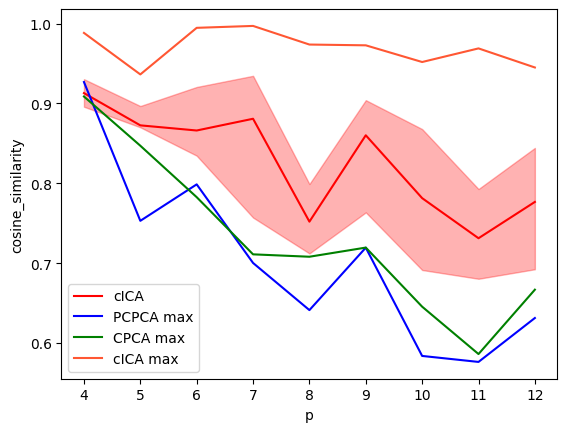

In [12]:
CICA_75=[]
CICA_median=[]
CICA_25=[]
CICA_max=[]
CPCA_75=[]
CPCA_median=[]
CPCA_25=[]
HTD_75=[]   
HTD_median=[]
HTD_25=[]
PCPCA_75=[]
PCPCA_median=[]
PCPCA_25=[]
PCPCA_max=[]
CPCA_max=[]
HTD_max=[]
for n in range(4,13):
    a=np.mean(np.load(f'toy_example/pcpca_cosine_list_{n}.npy'),axis=1)
    b=np.mean(np.load(f'toy_example/cosine_list_{n}.npy'),axis=1)
    c=np.mean(np.load(f'toy_example/CPCA_cosine_list_{n}.npy'),axis=1)
    d=np.mean(np.load(f'toy_example/HTD_cosine_list_{n}.npy'),axis=1)
    PCPCA_75.append(np.quantile(a,0.75))
    PCPCA_median.append(np.median(a))
    PCPCA_25.append(np.quantile(a,0.25))
    PCPCA_max.append(np.max(a))

    CICA_75.append(np.quantile(b,0.75))
    CICA_median.append(np.median(b))
    CICA_25.append(np.quantile(b,0.25))
    CICA_max.append(np.max(b))

    CPCA_75.append(np.quantile(c,0.75))
    CPCA_median.append(np.median(c))
    CPCA_25.append(np.quantile(c,0.25))
    CPCA_max.append(np.max(c))

    HTD_75.append(np.quantile(d,0.75))
    HTD_median.append(np.median(d))
    HTD_25.append(np.quantile(d,0.25))
    HTD_max.append(np.max(d))

plt.plot(range(4,13),CICA_median,label='cICA',color='red')
plt.fill_between(range(4,13), CICA_25, CICA_75, color='red', alpha=0.3)

plt.plot(range(4,13),PCPCA_max,label='PCPCA max',color='blue')

plt.plot(range(4,13),CPCA_max,label='CPCA max',color='green')

plt.plot(range(4,13),CICA_max,label='cICA max',color='#FF5733')

plt.xlabel('p')
plt.ylabel('cosine_similarity')
plt.legend()

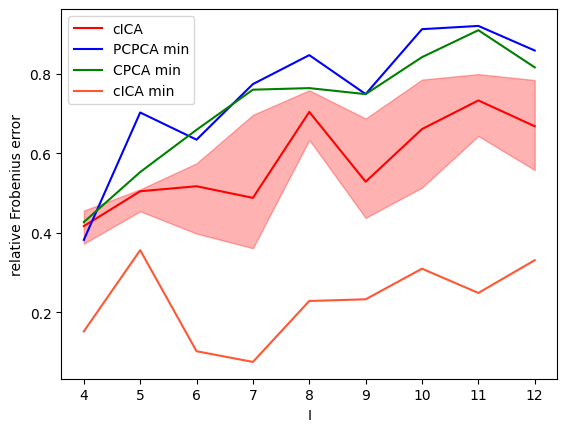

In [13]:
CICA_75=[]
CICA_median=[]
CICA_25=[]
CICA_min=[]
CPCA_75=[]
CPCA_median=[]
CPCA_25=[]
HTD_75=[]   
HTD_median=[]
HTD_25=[]
PCPCA_75=[]
PCPCA_median=[]
PCPCA_25=[]
PCPCA_min=[]
CPCA_min=[]
HTD_min=[]
for n in range(4,13):
    a=np.load(f'toy_example/pcpca_rel_frob_list_{n}.npy')
    b=np.load(f'toy_example/rel_frob_list_{n}.npy')
    c=np.load(f'toy_example/CPCA_rel_frob_list_{n}.npy')
    d=np.load(f'toy_example/HTD_rel_frob_list_{n}.npy')
    PCPCA_75.append(np.quantile(a,0.75))
    PCPCA_median.append(np.median(a))
    PCPCA_25.append(np.quantile(a,0.25))
    PCPCA_min.append(np.min(a))

    CICA_75.append(np.quantile(b,0.75))
    CICA_median.append(np.median(b))
    CICA_25.append(np.quantile(b,0.25))
    CICA_min.append(np.min(b))

    CPCA_75.append(np.quantile(c,0.75))
    CPCA_median.append(np.median(c))
    CPCA_25.append(np.quantile(c,0.25))
    CPCA_min.append(np.min(c))

    HTD_75.append(np.quantile(d,0.75))
    HTD_median.append(np.median(d))
    HTD_25.append(np.quantile(d,0.25))
    HTD_min.append(np.min(d))


# plt.plot(range(4,13),CICA_median,label='cICA',color='red')
# plt.fill_between(range(4,13), CICA_25, CICA_75, color='red', alpha=0.3)

# plt.plot(range(4,13),HTD_median,label='HTD',color='purple')
# plt.fill_between(range(4,13), HTD_25, HTD_75, color='purple', alpha=0.3)

# plt.plot(range(4,13),PCPCA_median,label='PCPCA',color='blue')
# plt.fill_between(range(4,13), PCPCA_25, PCPCA_75, color='blue', alpha=0.3)

# plt.plot(range(4,13),CPCA_median,label='CPCA',color='green')
# plt.fill_between(range(4,13), CPCA_25, CPCA_75, color='green', alpha=0.3)


# plt.xlabel('I')
# plt.ylabel('relative Frobenius error')
# plt.legend()

# plt.figure()

# plt.plot(range(4,13),CICA_min,label='cICA',color='red')

# plt.plot(range(4,13),HTD_min,label='HTD',color='purple')

# plt.plot(range(4,13),PCPCA_min,label='PCPCA',color='blue')

# plt.plot(range(4,13),CPCA_min,label='CPCA',color='green')

# plt.xlabel('I')
# plt.ylabel('relative Frobenius error min')

# plt.figure()
# plt.plot(range(4,13),CICA_median,label='cICA',color='red')
# plt.fill_between(range(4,13), CICA_25, CICA_75, color='red', alpha=0.3)

# plt.plot(range(4,13),PCPCA_median,label='PCPCA',color='blue')
# plt.fill_between(range(4,13), PCPCA_25, PCPCA_75, color='blue', alpha=0.3)

# plt.plot(range(4,13),CPCA_median,label='CPCA',color='green')
# plt.fill_between(range(4,13), CPCA_25, CPCA_75, color='green', alpha=0.3)


# plt.xlabel('I')
# plt.ylabel('relative Frobenius error')
# plt.legend()

# plt.figure()

# plt.plot(range(4,13),CICA_min,label='cICA',color='red')

# plt.plot(range(4,13),PCPCA_min,label='PCPCA',color='blue')

# plt.plot(range(4,13),CPCA_min,label='CPCA',color='green')

# plt.xlabel('I')
# plt.ylabel('relative Frobenius error min')
# plt.legend()




# plt.figure()

# plt.plot(range(4,13),CICA_median,label='cICA',color='red')
# plt.fill_between(range(4,13), CICA_25, CICA_75, color='red', alpha=0.3)

# plt.plot(range(4,13),HTD_min,label='HTD',color='purple')

# plt.plot(range(4,13),PCPCA_min,label='PCPCA',color='blue')

# plt.plot(range(4,13),CPCA_min,label='CPCA',color='green')

# plt.xlabel('I')
# plt.ylabel('relative Frobenius error')
# plt.legend()




# plt.figure()

plt.plot(range(4,13),CICA_median,label='cICA',color='red')
plt.fill_between(range(4,13), CICA_25, CICA_75, color='red', alpha=0.3)

plt.plot(range(4,13),PCPCA_min,label='PCPCA min',color='blue')

plt.plot(range(4,13),CPCA_min,label='CPCA min',color='green')

plt.plot(range(4,13),CICA_min,label='cICA min',color='#FF5733')

plt.xlabel('I')
plt.ylabel('relative Frobenius error')
plt.legend()

# proportional setting

In [ ]:
best_gamma=[]
for n in range(4,13):
    Q=np.load(f'toy_example/Q_{n}_{n}.npy')
    B=Q[:,1:]
    A=np.load(f'toy_example/A_{n}_{n}.npy')
    n_samples=100000
    np.random.seed(0)
    y=np.zeros((n-1,n_samples))
    scale_3=[2,1.5]*n
    for i in range(n-1):
        y[i,:]=np.random.exponential(scale_3[i],size=n_samples)
    x_1=np.random.exponential(2,size=(n,n_samples))
    x_2=np.random.exponential(2,size=(n,n_samples))
    X=A@x_2+B@y
    Y=A@x_1
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    np.save(f'toy_example_2/X_{n}',X)
    np.save(f'toy_example_2/Y_{n}',Y)

    CPCA_cosine_list=[]
    CPCA_rel_frob_list=[]
    alphas=np.logspace(-4,4,num=100)
    for alpha in alphas:
        D,V=eig2(k2_f-alpha*k2_b)
        b_cpca=V[:,:n-1]
        cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_cpca,B)
        CPCA_cosine_list.append(cosine_sim_list)
        CPCA_rel_frob_list.append(relfroberror)
    np.save(f'toy_example_2/CPCA_cosine_list_{n}',np.array(CPCA_cosine_list))
    np.save(f'toy_example_2/CPCA_rel_frob_list_{n}',np.array(CPCA_rel_frob_list))
    HTD_cosine_list=[]
    HTD_rel_frob_list=[]
    for alpha in alphas: 
        gamma=np.sqrt(alpha)
        b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,n-1)
        cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_s_sorted,B)
        HTD_cosine_list.append(cosine_sim_list)
        HTD_rel_frob_list.append(relfroberror)
    cosine_array=np.array(HTD_cosine_list)
    index=np.argmax(np.mean(cosine_array,axis=1))
    best_gamma.append(np.sqrt(alphas)[index])
    np.save(f'toy_example_2/HTD_cosine_list_{n}',np.array(HTD_cosine_list))
    np.save(f'toy_example_2/HTD_rel_frob_list_{n}',np.array(HTD_rel_frob_list))

In [ ]:
X=np.load(f'toy_example_2/X_{n}.npy')
Y=np.load(f'toy_example_2/Y_{n}.npy')
k2_f,k4_f=cumulant_tensors(X.T)
k2_b,k4_b=cumulant_tensors(Y.T)

In [ ]:
gamma_list=[]
for n in range(4,13):
    X=np.load(f'toy_example_2/X_{n}.npy')
    Y=np.load(f'toy_example_2/Y_{n}.npy')
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    I=k4_b.shape[0]
    a_s,lambdas=subspace_power_method(k4_b,n=4,d=n,r=n)
    def returnmindistancebewteenvectors(cols):
        def distancebewteenvectors(v1,v2):
            v1=v1.reshape(-1,1)
            v2=v2.reshape(-1,1)
            M=v1@np.transpose(v1)-v2@np.transpose(v2)
            return np.sum(M*M)
        lens=cols.shape[1]
        error=1
        for i in range(lens):
            for j in range(i+1,lens):
                error=min(error,max(distancebewteenvectors(cols[:,i],cols[:,j]),distancebewteenvectors(cols[:,i],-cols[:,j])))
        return error
    step=0
    step_max=100
    while returnmindistancebewteenvectors(a_s)<0.1 and step<step_max:
        a_s,lambdas=subspace_power_method(k4_b,n=4,d=n,r=n)
        step+=1
    k4_f_copy=k4_f.copy()
    matK4f=k4_f_copy.reshape(I**2,I**2)
    symind, findsym, symindscale = symmetric_indices(I, 2)
    symindscale = np.sqrt(symindscale)
    findsym = findsym.flatten()
    symind = symind[::-1,:].T @ (I ** np.arange(2))
    sym_matK4f = symindscale.reshape(1, -1) * matK4f[symind][:, symind] * symindscale.reshape(-1, 1)
    D, symV = eig2(sym_matK4f)
    eigtol= 1e-12
    rank_k4_f=D.shape[0] - np.searchsorted(abs(D[::-1]), eigtol)
    D = D[:rank_k4_f]
    V = (symV[:, :rank_k4_f] / symindscale.reshape(-1, 1))[findsym, :]
    D1 = np.diagflat(1. / D).T
    # learn coefficients of a_i in k4_f
    lambda_prime=[]
    for a in a_s.T:
        apow = khatri_rao_power(a.reshape(-1, 1), 2)
        alpha = (apow.T @ V).T
        D1alpha = D1 @ alpha
        scalar=(alpha.T @ D1alpha)[0,0]
        k4_f_copy-=(1. / scalar)*generate_lowrank_tensor(a.reshape(-1,1),4)
        lambda_prime.append(1./scalar)
        matK4f=k4_f_copy.reshape(I**2,I**2)
        sym_matK4f = symindscale.reshape(1, -1) * matK4f[symind][:, symind] * symindscale.reshape(-1, 1)
        D, symV = eig2(sym_matK4f)
        eigtol= 1e-12
        rank_k4_f=D.shape[0] - np.searchsorted(abs(D[::-1]), eigtol)
        D = D[:rank_k4_f]
        V = (symV[:, :rank_k4_f] / symindscale.reshape(-1, 1))[findsym, :]
        D1 = np.diagflat(1. / D).T
    lamdas=np.array(lambdas)
    lambda_prime=np.array(lambda_prime)
    gamma_list.append(np.product(lambda_prime**(1/n))/np.product(lambdas**(1/n)))
    print(n,np.product(lambda_prime**(1/n))/np.product(lambdas**(1/n)))


In [66]:
np.save('toy_example_2/gamma_list_computed_via_thm',gamma_list)
gamma_list

array([1.07443516, 1.01543858, 1.01750544, 1.06566841, 0.94774252,
       0.95222673, 1.04673448, 1.00977242, 1.01859887])

In [59]:
HTD_cosine_list=[]
HTD_rel_frob_list=[]
for n in [7,10]:
    print(n)
    X=np.load(f'toy_example_2/X_{n}.npy')
    Y=np.load(f'toy_example_2/Y_{n}.npy')
    B=np.load(f'toy_example/Q_{n}_{n}.npy')[:,1:]
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    index=n-4
    gamma=gamma_list[index]
    b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,n-1)
    cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_s_sorted,B)
    
    HTD_cosine_list.append(np.mean(cosine_sim_list))
    HTD_rel_frob_list.append(relfroberror)

np.save('toy_example_2/HTD_cosine_list',np.array(HTD_cosine_list))
np.save('toy_example_2/HTD_rel_frob_list',np.array(HTD_rel_frob_list))


In [ ]:
for n in range(4,13):
    X=np.load(f'toy_example_2/X_{n}.npy')
    Y=np.load(f'toy_example_2/Y_{n}.npy')
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    B=np.load(f'toy_example/Q_{n}_{n}.npy')[:,1:]
    pcpca_cosine_list=[]
    pcpca_rel_frob_list=[]
    likelihood=[]
    for i,gamma in enumerate(np.linspace(0,0.9,100)):
            pcpca = PCPCA(gamma=gamma, n_components=n-1)
            pcpca.fit(X,Y)
            pcpca_B=pcpca.W_mle
            pcpca_B=pcpca_B/np.linalg.norm(pcpca_B,axis=0)
            cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(pcpca_B,B)
            pcpca_cosine_list.append(cosine_sim_list)
            pcpca_rel_frob_list.append(relfroberror)  
    np.save(f'toy_example_2/pcpca_cosine_list_{n}',np.array(pcpca_cosine_list))
    np.save(f'toy_example_2/pcpca_rel_frob_list_{n}',np.array(pcpca_rel_frob_list))

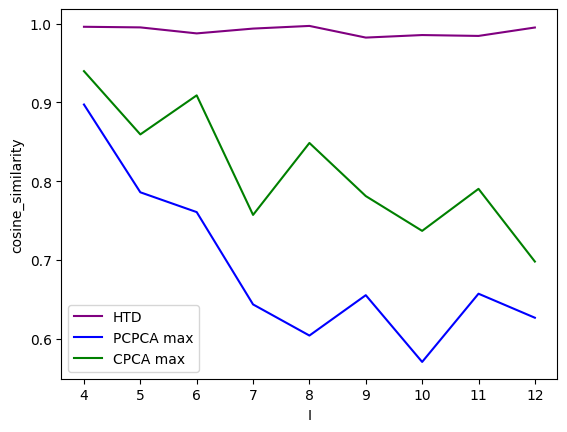

In [69]:
CICA_75=[]
CICA_median=[]
CICA_25=[]
CICA_max=[]
CPCA_75=[]
CPCA_median=[]
CPCA_25=[]
PCPCA_75=[]
PCPCA_median=[]
PCPCA_25=[]
PCPCA_max=[]
CPCA_max=[]
# HTD_max=[]
for n in range(4,13):
    a=np.mean(np.load(f'toy_example_2/pcpca_cosine_list_{n}.npy'),axis=1)
    c=np.mean(np.load(f'toy_example_2/CPCA_cosine_list_{n}.npy'),axis=1)
    PCPCA_75.append(np.quantile(a,0.75))
    PCPCA_median.append(np.median(a))
    PCPCA_25.append(np.quantile(a,0.25))
    PCPCA_max.append(np.max(a))

    CPCA_75.append(np.quantile(c,0.75))
    CPCA_median.append(np.median(c))
    CPCA_25.append(np.quantile(c,0.25))
    CPCA_max.append(np.max(c))

plt.plot(range(4,13),HTD_cosine_list,label='HTD',color='purple')

plt.plot(range(4,13),PCPCA_max,label='PCPCA max',color='blue')

plt.plot(range(4,13),CPCA_max,label='CPCA max',color='green')

plt.xlabel('I')
plt.ylabel('cosine_similarity')
plt.legend()


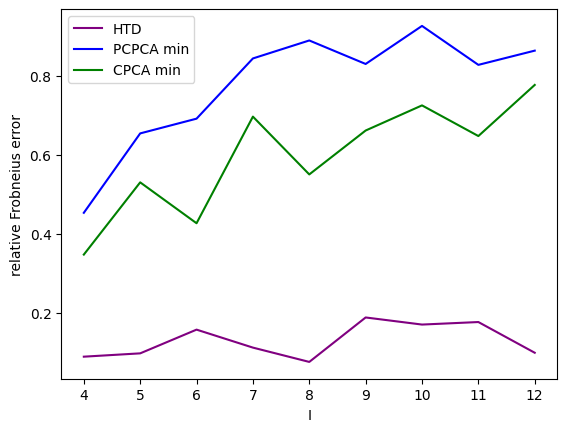

In [70]:
CPCA_75=[]
CPCA_median=[]
CPCA_25=[]
HTD_75=[]   
HTD_median=[]
HTD_25=[]
PCPCA_75=[]
PCPCA_median=[]
PCPCA_25=[]
PCPCA_min=[]
CPCA_min=[]
for n in range(4,13):
    a=np.load(f'toy_example_2/pcpca_rel_frob_list_{n}.npy')
    c=np.load(f'toy_example_2/CPCA_rel_frob_list_{n}.npy')
    PCPCA_75.append(np.quantile(a,0.75))
    PCPCA_median.append(np.median(a))
    PCPCA_25.append(np.quantile(a,0.25))
    PCPCA_min.append(np.min(a))

    CPCA_75.append(np.quantile(c,0.75))
    CPCA_median.append(np.median(c))
    CPCA_25.append(np.quantile(c,0.25))
    CPCA_min.append(np.min(c))

plt.plot(range(4,13),HTD_rel_frob_list,label='HTD',color='purple')
plt.plot(range(4,13),PCPCA_min,label='PCPCA min',color='blue')

plt.plot(range(4,13),CPCA_min,label='CPCA min',color='green')

plt.xlabel('I')
plt.ylabel('relative Frobneius error')
plt.legend()
